# BANA-212 Final Project: Used Car Analysis
### Group 22: William Leonard, Susan Mikhail, Matthias Ronnau, Lokesh Nandni Sood, Parsa Tahmasebi

## Import Packages and Read in the Data

In [271]:
#Import packages
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#Read in the data
vehicles = pd.read_csv("vehicles.csv")

In [97]:
#Take a look at the data
cars = vehicles.copy()
cars.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7184791621,https://duluth.craigslist.org/ctd/d/duluth-200...,duluth / superior,https://duluth.craigslist.org,6995,2000.00000,gmc,new sierra 1500,excellent,8 cylinders,...,4wd,NaN,NaN,red,https://images.craigslist.org/00n0n_f06ykBMcdh...,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,nan,mn,46.84330,-92.25500
1,7184773187,https://duluth.craigslist.org/cto/d/saginaw-20...,duluth / superior,https://duluth.craigslist.org,8750,2013.00000,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,NaN,grey,https://images.craigslist.org/00d0d_kgZ6xoeRw2...,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,nan,mn,46.90740,-92.46380
2,7193375964,https://newhaven.craigslist.org/cto/d/stratfor...,new haven,https://newhaven.craigslist.org,10900,2013.00000,toyota,prius,good,4 cylinders,...,fwd,NaN,NaN,blue,https://images.craigslist.org/00d0d_3sHGxPbY2O...,2013 Prius V Model Two. One owner—must sell my...,nan,ct,41.17700,-73.13360
3,7195108810,https://albuquerque.craigslist.org/cto/d/albuq...,albuquerque,https://albuquerque.craigslist.org,12500,2003.00000,mitsubishi,lancer,good,4 cylinders,...,4wd,mid-size,sedan,grey,https://images.craigslist.org/00m0m_4a8Pb6JbMG...,"2003 Mitsubishi Lancer Evolution, silver. Abo...",nan,nm,35.18680,-106.66500
4,7184712241,https://duluth.craigslist.org/ctd/d/rush-city-...,duluth / superior,https://duluth.craigslist.org,16995,2007.00000,gmc,sierra classic 2500hd,good,8 cylinders,...,4wd,full-size,truck,white,https://images.craigslist.org/01414_g093aPtSMW...,"**Bad Credit, No Credit... No Problem!**2007 G...",nan,mn,45.68360,-92.96480


## Exploratory Data Analysis and Data Cleaning

### Initial Data Cleaning

In [98]:
cars.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [99]:
#Remove columns unnescessary for the analysis
cars.drop(["id", "url", "region", "region_url", "model", "vin", "image_url", "county", "lat", "long"], axis = 1, inplace = True)
cars.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state
0,6995,2000.00000,gmc,excellent,8 cylinders,gas,167783.00000,clean,automatic,4wd,NaN,NaN,red,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,mn
1,8750,2013.00000,hyundai,excellent,4 cylinders,gas,90821.00000,clean,automatic,fwd,NaN,NaN,grey,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,mn
2,10900,2013.00000,toyota,good,4 cylinders,hybrid,92800.00000,clean,automatic,fwd,NaN,NaN,blue,2013 Prius V Model Two. One owner—must sell my...,ct
3,12500,2003.00000,mitsubishi,good,4 cylinders,gas,nan,clean,manual,4wd,mid-size,sedan,grey,"2003 Mitsubishi Lancer Evolution, silver. Abo...",nm
4,16995,2007.00000,gmc,good,8 cylinders,diesel,254217.00000,clean,automatic,4wd,full-size,truck,white,"**Bad Credit, No Credit... No Problem!**2007 G...",mn


In [100]:
#Look at the number and percent of missing values for each column
missing = pd.DataFrame(cars.isna().sum())
missing.columns = ["num_missing"]
missing["percent_missing"] = missing.num_missing / len(cars.index)
missing

,num_missing,percent_missing
price,0,0.00000
year,95114,0.22440
manufacturer,110615,0.26097
condition,247138,0.58307
cylinders,226178,0.53362
fuel,96643,0.22801
odometer,153272,0.36161
title_status,96098,0.22672
transmission,95792,0.22600
drive,192738,0.45472


In [101]:
cars.drop("size", axis = 1, inplace = True)

In [106]:
#Restructure the column "cylinders" by only keeping the number of cylinders and removing any text from the column
cars["cylinders"].unique()
cars["cylinders"] = cars["cylinders"].fillna("")
cars["cylinders"] = pd.Series([int(x) if x.isdigit() else np.nan for x in [re.sub("[^0-9]", "", y) 
                                                                           for y in list(cars["cylinders"])]])

In [107]:
#Get descriptive statistics for the price, year of manufacture, number of cylinders, and mileage of each car
cars.describe()

,price,year,cylinders,odometer
count,423857.00000,328743.00000,196828.00000,270585.00000
mean,57794.37478,2009.82736,5.85220,99425.78461
std,10025805.11645,10.13581,1.61935,120483.31239
min,0.00000,1900.00000,3.00000,0.00000
25%,4499.00000,2007.00000,4.00000,44324.00000
50%,9995.00000,2012.00000,6.00000,91749.00000
75%,18995.00000,2016.00000,8.00000,137237.00000
max,3808256046.00000,2021.00000,12.00000,10000000.00000


### Investigating the Price Column

In [108]:
#The max price seems very odd, let's take a look
cars.loc[cars["price"] == 3808256046.00000]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
300026,3808256046,2007.00000,saturn,good,nan,gas,nan,clean,automatic,NaN,NaN,red,"2007 Saturn Aura has 140,224 miles on it. Grea...",mi


In [109]:
list(cars.loc[cars["price"] == 3808256046.00000]["description"])

['2007 Saturn Aura has 140,224 miles on it. Great running car no check engine light on. ac and heat both work. Radio works power windows and locks. Has a sunroof works as well. Have two set of keys with automatic start. Asking for 3,000 willing to go down in price.  show contact info']

The description says that the seller is asking for $3000, so we can impute that value for the price.

In [110]:
#Impute 3000 for the price, overwriting the eroneous value that was present.
cars.iloc[300026, 0] = 3000

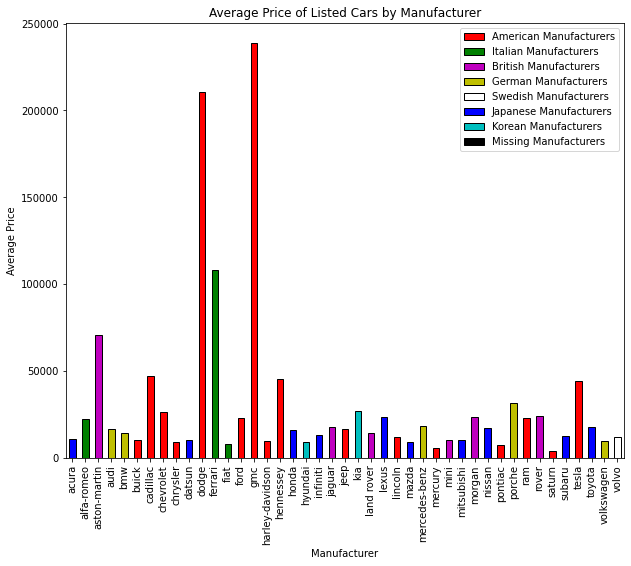

In [111]:
colors = ["b", "g", "m", "y", "y", "r", "r", "r", "r", "b", "r", "g", "g", "r", "r", "r", "r", "b", "c", "b", "m", 
         "r", "c", "m", "b", "r", "b", "y", "r", "m", "b", "m", "b", "r", "y", "r", "m", "r", "b", "r", "b", "y", "w"]

plt.figure(figsize = (10, 8))
cars.groupby("manufacturer").price.mean().plot.bar(color = colors, edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Manufacturer")
american = mpatches.Patch(facecolor = "r", edgecolor = "k", label = "American Manufacturers")
italian = mpatches.Patch(facecolor = "g", edgecolor = "k", label = "Italian Manufacturers")
british = mpatches.Patch(facecolor = "m", edgecolor = "k", label = "British Manufacturers")
german = mpatches.Patch(facecolor = "y", edgecolor = "k", label = "German Manufacturers")
swedish = mpatches.Patch(facecolor = "w", edgecolor = "k", label = "Swedish Manufacturers")
japanese = mpatches.Patch(facecolor = "b", edgecolor = "k", label = "Japanese Manufacturers")
korean = mpatches.Patch(facecolor = "c", edgecolor = "k", label = "Korean Manufacturers")
missing = mpatches.Patch(facecolor = "k", edgecolor = "k", label = "Missing Manufacturers")
plt.title("Average Price of Listed Cars by Manufacturer")
plt.legend(handles = [american, italian, british, german, swedish, japanese, korean, missing])

Dodge and GMC, which are not known to be "high end" vehicles, show a mean price that is larger than luxury brands like Aston-Martin and Ferrari. This seems od, so let's investigate.

In [112]:
cars.loc[cars["manufacturer"] == "dodge"]["price"].describe()

count        12547.00000
mean        210606.10489
std       22234124.01268
min              0.00000
25%           3481.50000
50%           8495.00000
75%          17995.00000
max     2490531375.00000
Name: price, dtype: float64

In [113]:
cars.loc[cars["price"] == 2490531375.00000]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
67033,2490531375,2014.00000,dodge,good,4.00000,gas,112589.00000,clean,automatic,fwd,sedan,red,"J.P. AUTO ENTERPRISE 3558 BUFORD HWY, SUITE B-...",ga


In [114]:
list(cars.loc[cars["price"] == 2490531375.00000]["description"])

['J.P. AUTO ENTERPRISE 3558 BUFORD HWY, SUITE B-100 DULUTH, GA 30096 CEL: 678-549-8671 www.jpcarsandbikes.com  Information VIN: 1C3CDFBB6ED695611 Make: Dodge Model: Dart  Model Year: 2014 Trim Package: SXT 4 Door Sedan  Body Style: Sedan  Engine: 2.4L I4 Fuel Type: Gasoline Drivetrain: FWD']

Seeing that there is no info regarding the price in the description, we should remove this data point as it is likely an error.

In [115]:
cars.drop(index = 67033, inplace = True)

In [116]:
cars.loc[cars["manufacturer"] == "gmc"]["price"].describe()

count        12782.00000
mean        238584.92974
std       24839841.83032
min              0.00000
25%           6850.00000
50%          14000.00000
75%          27990.00000
max     2808348671.00000
Name: price, dtype: float64

In [117]:
cars.loc[cars["price"] == 2808348671.00000]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
207260,2808348671,2020.00000,gmc,NaN,8.00000,gas,nan,clean,automatic,NaN,NaN,NaN,"WILL BUY YOU RLIFTED OR LOWERED TRUCK , SINGLE...",ca


In [118]:
list(cars.loc[cars["price"] == 2808348671.00000]["description"])

['WILL BUY YOU RLIFTED OR LOWERED TRUCK , SINGLE CABS SHORT BED , JEEPS LIFTED OR CUSTOM     WILL PAY CASH  PLEASE CALL US     (209)544-1388']

Seeing that there is no info regarding the price in the description, we should remove this data point as it is likely an error.

In [119]:
cars.drop(index = 207260, inplace = True)

In [120]:
cars["price"].describe()

count       423855.00000
mean         36308.21205
std        5749884.40163
min              0.00000
25%           4499.00000
50%           9995.00000
75%          18995.00000
max     2632269824.00000
Name: price, dtype: float64

In [121]:
cars.drop(index = cars.loc[cars["price"] > 300000].index, inplace = True)

cars.drop(index = cars.loc[cars["price"] < 100].index, inplace = True)

cars.reset_index(inplace = True, drop = True)

In [122]:
cars["price"].describe()

count   386131.00000
mean     15221.11954
std      14036.89218
min        100.00000
25%       5900.00000
50%      11500.00000
75%      19995.00000
max     300000.00000
Name: price, dtype: float64

### Investigating the Odometer Column

In [123]:
#As seen above, the max value for the column "odometer" was 10000000.00. This seems unrealistic. Let's take a look.

cars.loc[cars["odometer"] == 10000000.00000]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
87271,38900,1990.00000,NaN,good,8.00000,diesel,10000000.00000,clean,manual,rwd,truck,grey,"This is a 1990 Peterbilt 379 long hood, has a ...",nj
179711,1400,2000.00000,chevrolet,good,8.00000,gas,10000000.00000,clean,automatic,4wd,truck,black,"Good work truck , 4x4 works , AC works PW wido...",oh
239615,3800,1936.00000,chevrolet,fair,6.00000,gas,10000000.00000,rebuilt,manual,rwd,sedan,black,"Four door 1936 chevy car, All parts are there....",sd
284243,6200,1915.00000,NaN,good,4.00000,gas,10000000.00000,missing,manual,rwd,truck,black,"Estate sale find, mostly restores 1915 Maxwell...",ia


Let's replace all unrealistic values for the column "odometer" (anything above 999999, the max reading on the odometer) with an estimate of what the mileage for a car of their age should be. According to [caranddriver.com](https://www.caranddriver.com/research/a32880477/average-mileage-per-year/), the average person drive 13,500 miles per year. We can find the age of each car that lists an unrealistic value, multiply this by 13,500, and impute that for the entry in odometer. If this value exceeds 999,999, we will impute 999,999 as the entry.

In [124]:
max_odometer_before_imputation = cars["odometer"].max()

In [125]:
cars["odometer"] = [x if x <= 999999 else min(999999, (13500 * (2021 - cars["year"][i]))) for i, x in enumerate(cars["odometer"])]

In [126]:
max_odometer_after_imputation = cars["odometer"].max()

In [127]:
print(max_odometer_before_imputation)
print(max_odometer_after_imputation)

10000000.0
999999.0


### Adding Identification Columns for Later Analysis

In [128]:
cars["manufacturer"].fillna("MISSING", inplace = True)

In [129]:
manufacturers = sorted(list(cars["manufacturer"].unique()))
nationalities = ["MISSING", "Japanese", "Italian", "British", "German", "German", "American", "American", "American", 
                 "American", "Japanese", "American", "Italian", "Italian", "American", "American", "American", "American", 
                "Japanese", "Korean", "Japanese", "British", "American", "Korean", "British", "Japanese", "American", 
                 "Japanese", "German", "American", "British", "Japanese", "British", "Japanese", "American", "German", 
                 "American", "British", "American", "Japanese", "American", "Japanese", "German", "Swedish"]

manufacturers_dictionary = {}
for i in range(len(manufacturers)):
    manufacturers_dictionary[manufacturers[i]] = nationalities[i]

In [130]:
cars["manufacturer_nationality"] = cars["manufacturer"].map(manufacturers_dictionary)

In [131]:
cars.groupby("manufacturer_nationality")["manufacturer_nationality"].count()

manufacturer_nationality
American    163929
British       3173
German       23129
Italian        681
Japanese     78107
Korean       14010
MISSING     101097
Swedish       2005
Name: manufacturer_nationality, dtype: int64

In [132]:
manufacturer_nationalities = sorted(list(cars["manufacturer_nationality"].unique()))
nationality_colors = ["r", "m", "y", "g", "b", "c", "k", "w"]

manufacturers_colors = {}
for i in range(len(manufacturer_nationalities)):
    manufacturers_colors[manufacturer_nationalities[i]] = nationality_colors[i]

cars["nationality_colors"] = cars["manufacturer_nationality"].map(manufacturers_colors)

In [133]:
cars["type"].unique()

array([nan, 'sedan', 'truck', 'SUV', 'other', 'mini-van', 'wagon',
       'hatchback', 'coupe', 'pickup', 'convertible', 'van', 'bus',
       'offroad'], dtype=object)

In [134]:
cars.loc[cars["type"] == "pickup", "type"] = "truck"

In [135]:
cars["type"].unique()

array([nan, 'sedan', 'truck', 'SUV', 'other', 'mini-van', 'wagon',
       'hatchback', 'coupe', 'convertible', 'van', 'bus', 'offroad'],
      dtype=object)

### Remove Missing Values

In [165]:
cars["manufacturer"].replace("MISSING", np.NaN, inplace = True)

In [172]:
missing = cars[cars.isnull().any(axis = 1)]
missing.shape

(294583, 16)

In [170]:
cars_no_missing = cars.copy()
cars_no_missing.dropna(inplace = True, axis = 0)
cars_no_missing.reset_index(inplace = True, drop = True)

In [171]:
cars_no_missing.shape

(91548, 16)

In [176]:
1 - (cars_no_missing.shape[0] / cars.shape[0])

0.7629094789074174

In [177]:
cars_no_missing.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'description', 'state', 'manufacturer_nationality',
       'nationality_colors'],
      dtype='object')

In [178]:
min_price = cars_no_missing["price"].min() - 1
price_25 = cars_no_missing["price"].quantile(0.25)
price_50 = cars_no_missing["price"].quantile(0.50)
price_75 = cars_no_missing["price"].quantile(0.75)
max_price = cars_no_missing["price"].max() + 1

price_binned = pd.cut(cars_no_missing["price"], bins = [min_price, price_25, price_50, price_75, max_price], 
       labels = ["Very Low", "Low", "Mid-High", "Expensive"])

In [179]:
cars_no_missing["price_binned"] = price_binned
cars_no_missing = cars_no_missing[[cars_no_missing.columns[0]] + [cars_no_missing.columns[-1]] + list(cars_no_missing.columns[1:-1])]

In [180]:
pd.DataFrame(cars_no_missing.groupby("manufacturer_nationality")["price"].count() / 91548)

,price
manufacturer_nationality,
American,0.57394
British,0.01179
German,0.08003
Italian,0.00230
Japanese,0.27836
Korean,0.04580
Swedish,0.00778


In [189]:
investigative_columns = ["price", "year", "manufacturer", "condition", "cylinders", "fuel",
       "odometer", "title_status", "transmission", "drive", "type",
       "paint_color", "description", "state"]

[Text(0.5, 0, 'Price'), Text(0, 0.5, 'Number of Listings')]

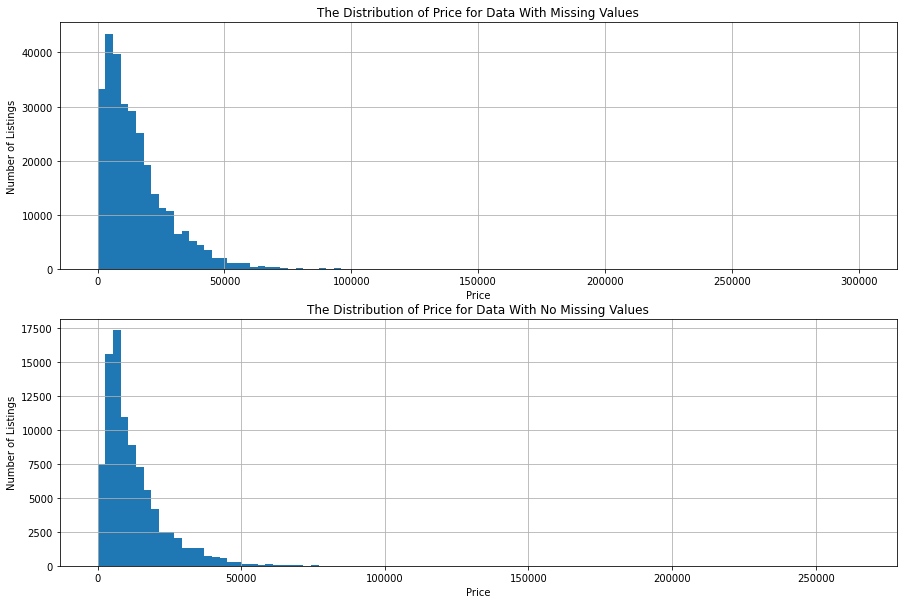

In [235]:
#Check distribution of price across missing and non-missing data
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
missing["price"].hist(ax = ax[0], bins = 100)
ax[0].set_title("The Distribution of Price for Data With Missing Values")
ax[0].set(xlabel = "Price", ylabel = "Number of Listings")
cars_no_missing["price"].hist(ax = ax[1], bins = 100)
ax[1].set_title("The Distribution of Price for Data With No Missing Values")
ax[1].set(xlabel = "Price", ylabel = "Number of Listings")

### Visualizations on Final Data

Text(0.5, 1.0, 'Heatmap of Continuous Predictors')

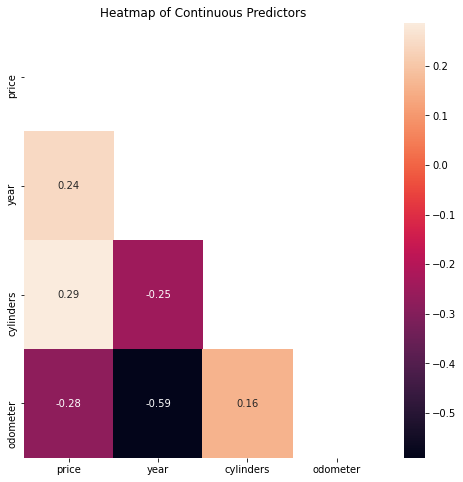

In [53]:
plt.figure(figsize = (8, 8))
mask = np.triu(np.ones_like(cars_no_missing.corr(), dtype=bool))
sns.heatmap(cars_no_missing.corr(), mask = mask, annot = True)
plt.title("Heatmap of Continuous Predictors")

Text(0.5, 1.0, 'Average List Price by Manufacturer')

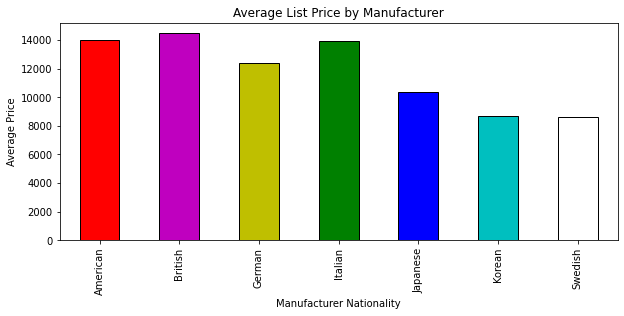

In [50]:
#Visualize the Mean List Price of Cars for Each Manufacturer
plt.figure(figsize = (10, 4))
cars_no_missing.groupby("manufacturer_nationality").price.mean().plot.bar(color = 
["r", "m", "y", "g", "b", "c", "w"], edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Manufacturer Nationality")
plt.title("Average List Price by Manufacturer")

Text(0.5, 1.0, 'Number of Listings by Manufacturer Nationality')

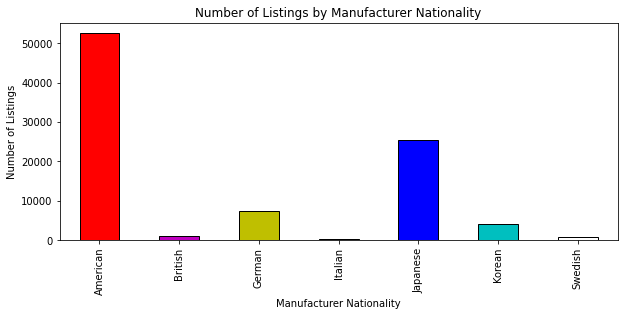

In [51]:
plt.figure(figsize = (10, 4))
cars_no_missing.groupby("manufacturer_nationality").price.count().plot.bar(color = 
["r", "m", "y", "g", "b", "c", "w"], edgecolor = "k")
plt.ylabel("Number of Listings")
plt.xlabel("Manufacturer Nationality")
plt.title("Number of Listings by Manufacturer Nationality")

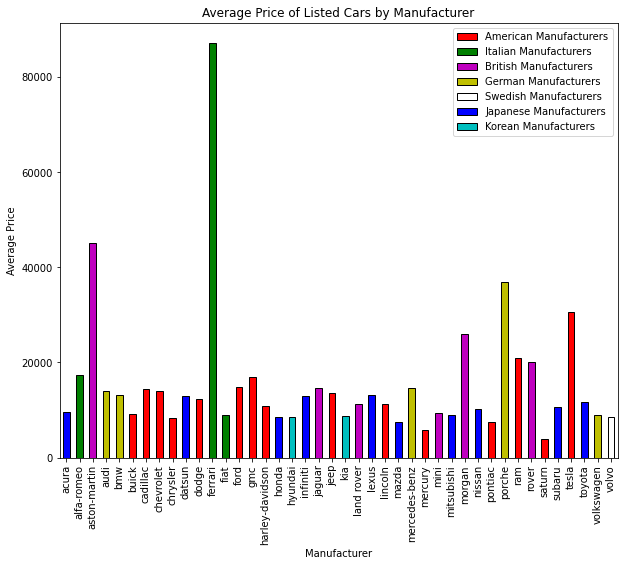

In [52]:
colors = ["b", "g", "m", "y", "y", "r", "r", "r", "r", "b", "r", "g", "g", "r", "r", "r", "b", "c", "b", "m", 
         "r", "c", "m", "b", "r", "b", "y", "r", "m", "b", "m", "b", "r", "y", "r", "m", "r", "b", "r", "b", "y", "w"]

plt.figure(figsize = (10, 8))
cars_no_missing.groupby("manufacturer").price.mean().plot.bar(color = colors, edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Manufacturer")
american = mpatches.Patch(facecolor = "r", edgecolor = "k", label = "American Manufacturers")
italian = mpatches.Patch(facecolor = "g", edgecolor = "k", label = "Italian Manufacturers")
british = mpatches.Patch(facecolor = "m", edgecolor = "k", label = "British Manufacturers")
german = mpatches.Patch(facecolor = "y", edgecolor = "k", label = "German Manufacturers")
swedish = mpatches.Patch(facecolor = "w", edgecolor = "k", label = "Swedish Manufacturers")
japanese = mpatches.Patch(facecolor = "b", edgecolor = "k", label = "Japanese Manufacturers")
korean = mpatches.Patch(facecolor = "c", edgecolor = "k", label = "Korean Manufacturers")
plt.title("Average Price of Listed Cars by Manufacturer")
plt.legend(handles = [american, italian, british, german, swedish, japanese, korean])

<Figure size 432x288 with 0 Axes>

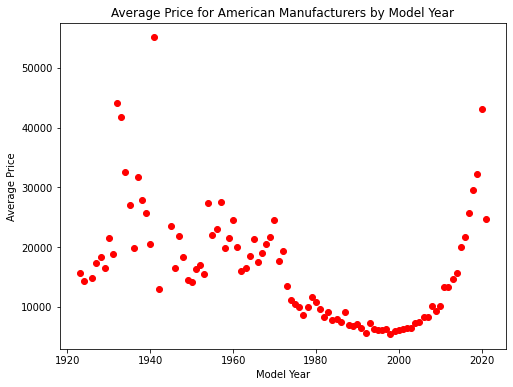

<Figure size 432x288 with 0 Axes>

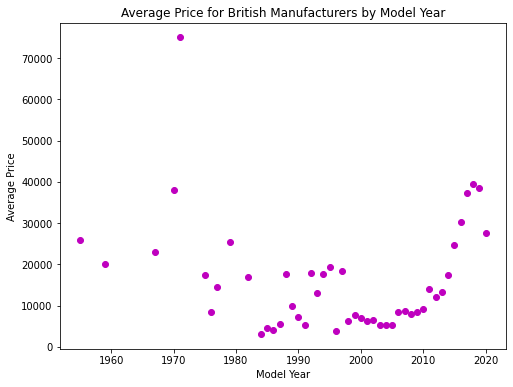

<Figure size 432x288 with 0 Axes>

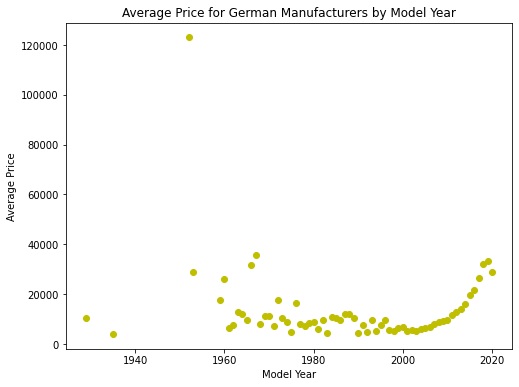

<Figure size 432x288 with 0 Axes>

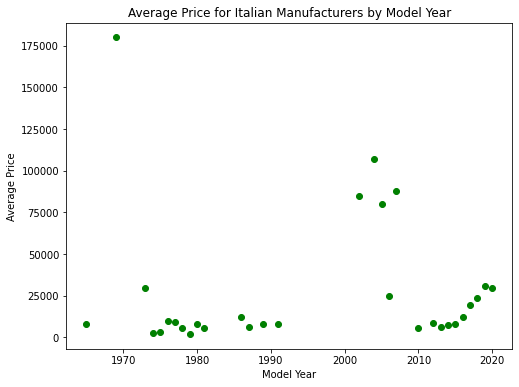

<Figure size 432x288 with 0 Axes>

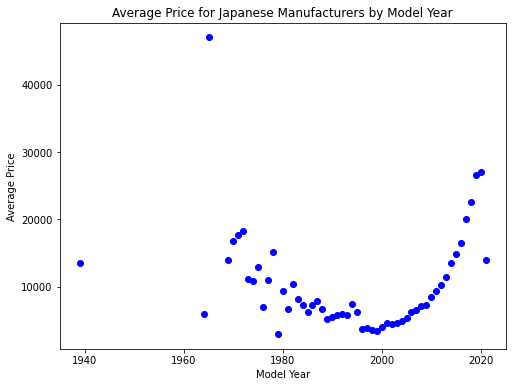

<Figure size 432x288 with 0 Axes>

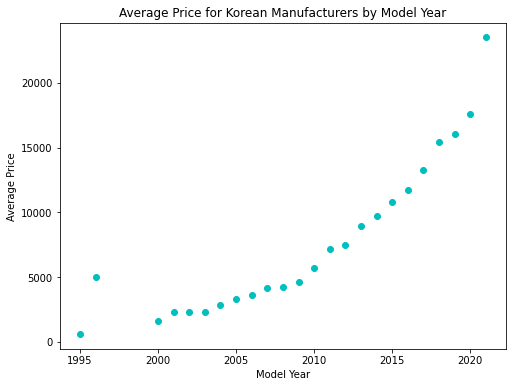

<Figure size 432x288 with 0 Axes>

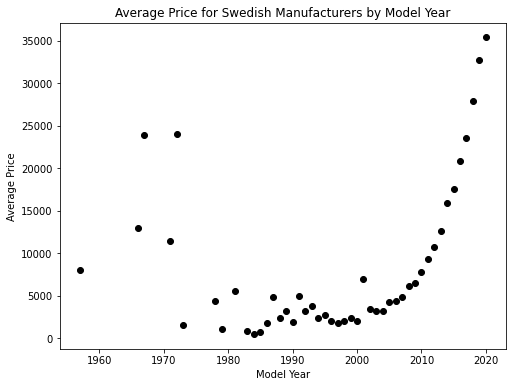

In [54]:
#Generate plots for each manufacturer denoting the mean price of cars listed for that year and plot it
no_missing_manufacturer_nationalities = sorted(list(cars_no_missing["manufacturer_nationality"].unique()))
no_missing_manufacturer_nationalities_colors = ["r", "m", "y", "g", "b", "c", "k"]

for i in range(len(no_missing_manufacturer_nationalities)):
    manufacturer_nationality = no_missing_manufacturer_nationalities[i]
    x = sorted(cars_no_missing[cars_no_missing["manufacturer_nationality"] ==  manufacturer_nationality]["year"].unique())
    y = cars_no_missing[cars_no_missing["manufacturer_nationality"] ==  manufacturer_nationality].groupby("year")["price"].mean()
    plt.figure()
    plt.figure(figsize = (8, 6))
    plt.scatter(x, y, color = no_missing_manufacturer_nationalities_colors[i])
    plt.xlabel("Model Year")
    plt.ylabel("Average Price")
    plt.title("Average Price for %s Manufacturers by Model Year" %manufacturer_nationality)
plt.show()

Text(0.5, 1.0, 'Average Price in Each Price Category')

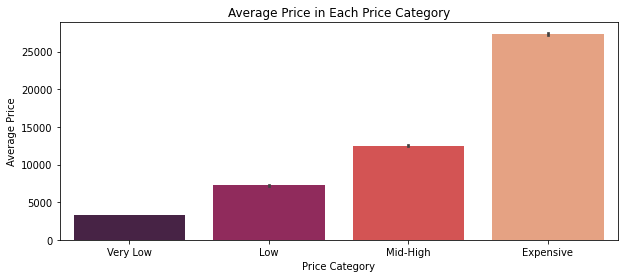

In [55]:
plt.figure(figsize = (10, 4))
sns.barplot(x = "price_binned", y = "price", data = cars_no_missing, palette = "rocket")
plt.xlabel("Price Category")
plt.ylabel("Average Price")
plt.title("Average Price in Each Price Category")

Text(0.5, 1.0, 'Average List Price by Fuel Type')

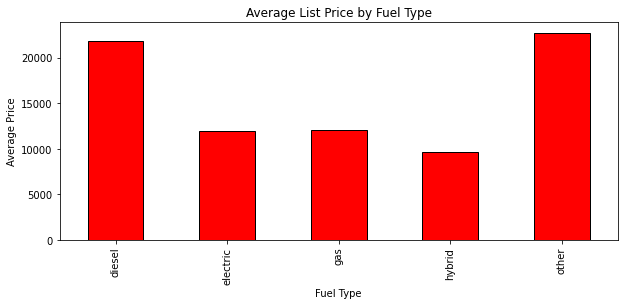

In [56]:
plt.figure(figsize = (10, 4))
cars_no_missing.groupby("fuel").price.mean().plot.bar(color = "r", edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Fuel Type")
plt.title("Average List Price by Fuel Type")

Text(0.5, 1.0, 'Average List Price by Drive Type')

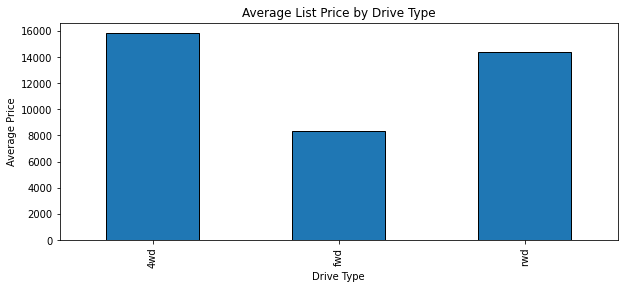

In [57]:
plt.figure(figsize = (10, 4))
cars_no_missing.groupby("drive").price.mean().plot.bar(edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Drive Type")
plt.title("Average List Price by Drive Type")

Text(0.5, 1.0, 'Average List Price by Transmission Type')

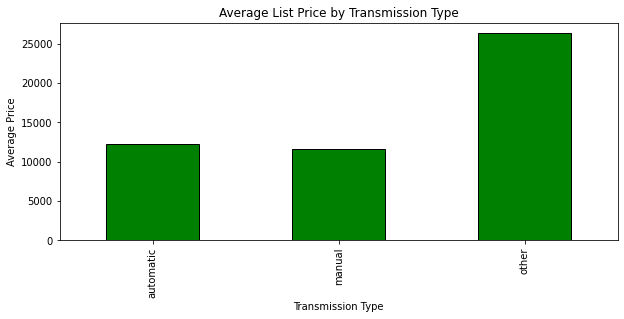

In [58]:
plt.figure(figsize = (10, 4))
cars_no_missing.groupby("transmission").price.mean().plot.bar(color = "g", edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Transmission Type")
plt.title("Average List Price by Transmission Type")

Text(0.5, 1.0, 'Average List Price by Condition')

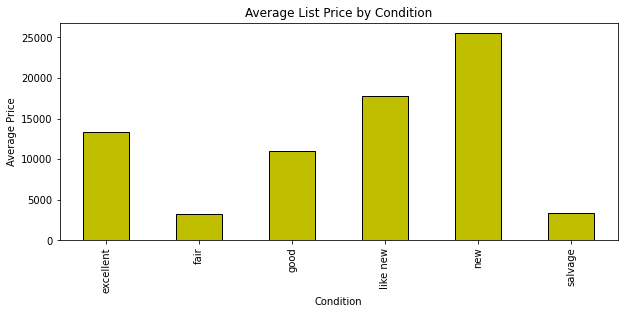

In [59]:
plt.figure(figsize = (10, 4))
cars_no_missing.groupby("condition").price.mean().plot.bar(color = "y", edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Condition")
plt.title("Average List Price by Condition")

Text(0.5, 0, 'Fuel Used')

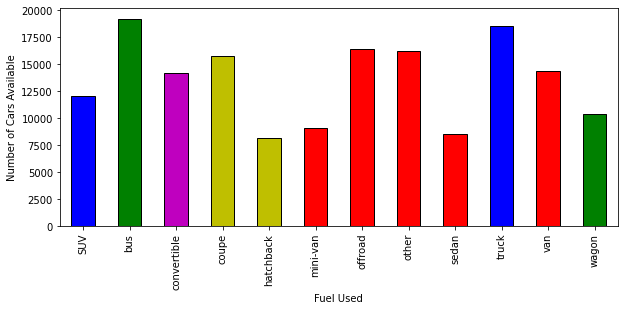

In [60]:
plt.figure(figsize = (10, 4))
cars_no_missing.groupby("type").price.mean().plot.bar(color = colors, edgecolor = "k")
plt.ylabel("Number of Cars Available")
plt.xlabel("Fuel Used")

Text(0.5, 1.0, 'Average Price of Listings by State')

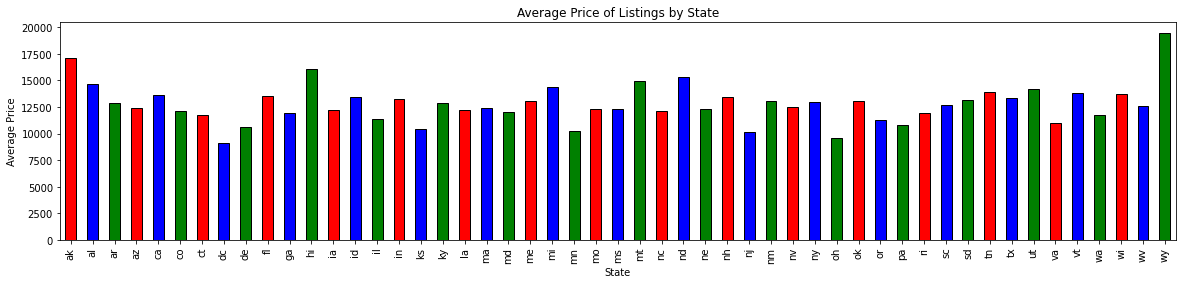

In [61]:
plt.figure(figsize = (20, 4))
cars_no_missing.groupby("state").price.mean().plot.bar(color = ["r", "b", "g"], edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("State")
plt.title("Average Price of Listings by State")

Text(0.5, 1.0, 'Number of Listings by State')

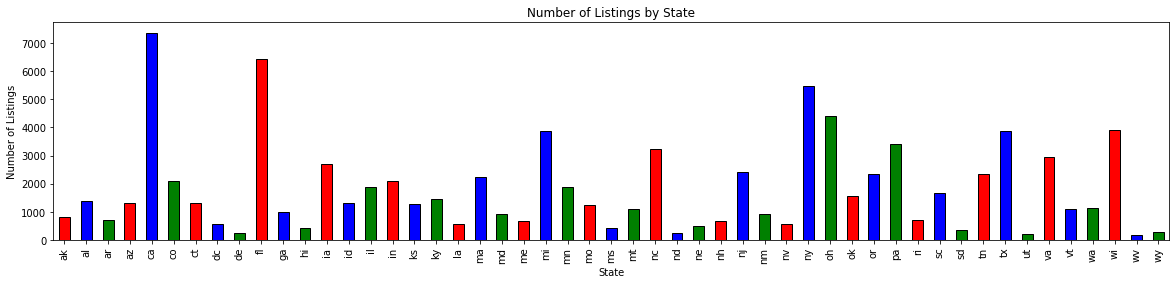

In [62]:
plt.figure(figsize = (20, 4))
cars_no_missing.groupby("state").price.count().plot.bar(color = ["r", "b", "g"], edgecolor = "k")
plt.ylabel("Number of Listings")
plt.xlabel("State")
plt.title("Number of Listings by State")

Text(0.5, 1.0, 'Average Price of Car by Model Year')

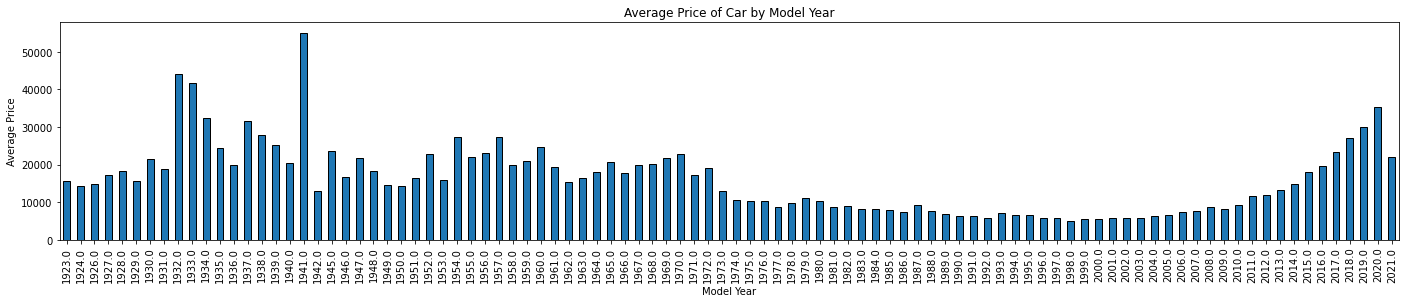

In [63]:
plt.figure(figsize = (24, 4))
cars_no_missing.groupby("year").price.mean().plot.bar(edgecolor = "k")
plt.ylabel("Average Price")
plt.xlabel("Model Year")
plt.title("Average Price of Car by Model Year")

Text(0.5, 1.0, 'Number of Listings by Model Year')

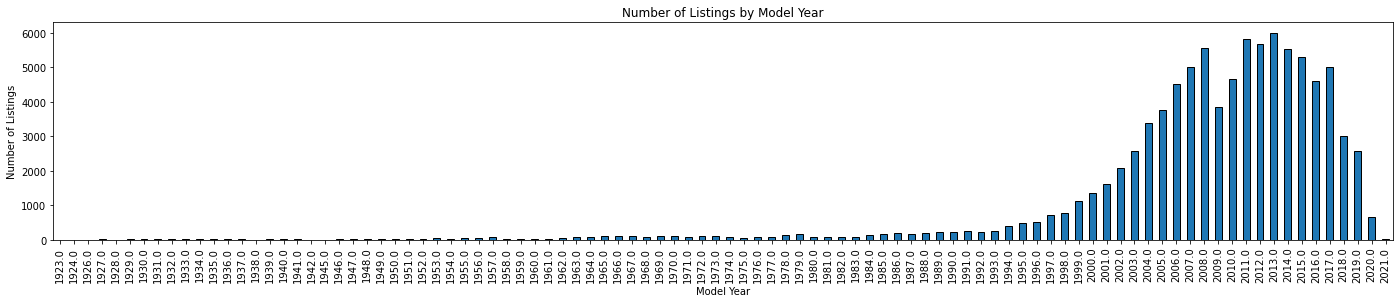

In [64]:
plt.figure(figsize = (24, 4))
cars_no_missing.groupby("year").price.count().plot.bar(edgecolor = "k")
plt.ylabel("Number of Listings")
plt.xlabel("Model Year")
plt.title("Number of Listings by Model Year")

### Convert Data to Proper Format for Regression and Models

In [65]:
numerical = cars_no_missing.loc[:, ["price", "year", "cylinders", "odometer"]]
categorical = cars_no_missing.loc[:, ["manufacturer", "condition", "fuel", "title_status", "transmission", "drive", 
                           "type", "paint_color", "state", "nationality_colors"]]
binned_prediction = cars_no_missing["price_binned"]

In [66]:
#Create k-1 dummy variables for each k-level categorical variable
categorical_dummies = pd.get_dummies(categorical.iloc[:, 0:9], drop_first = True)

In [67]:
cars_linear_data = pd.concat([numerical, categorical_dummies], axis = 1)
cars_linear_data.head()

,price,year,cylinders,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,12500,2003.00000,4.00000,243000.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16995,2007.00000,8.00000,254217.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13995,2012.00000,6.00000,188406.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7995,2010.00000,4.00000,108124.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8995,2011.00000,6.00000,178054.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
cars_linear_data["price"].describe()

count    91548.00000
mean     12592.59354
std      10954.67374
min        100.00000
25%       5295.00000
50%       9295.00000
75%      16488.00000
max     265000.00000
Name: price, dtype: float64

In [69]:
cars_price_binned = cars_linear_data.copy()
cars_price_binned["price_binned"] = binned_prediction
cars_price_binned.drop("price", axis = 1, inplace = True)
cars_price_binned = cars_price_binned[[cars_price_binned.columns[-1]] + list(cars_price_binned.columns[0:-1])]
cars_price_binned.head()

,price_binned,year,cylinders,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,Mid-High,2003.00000,4.00000,243000.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Expensive,2007.00000,8.00000,254217.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mid-High,2012.00000,6.00000,188406.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Low,2010.00000,4.00000,108124.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Low,2011.00000,6.00000,178054.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model Building

### Linear Regression

Text(0.5, 1.0, 'Distribution of Price')

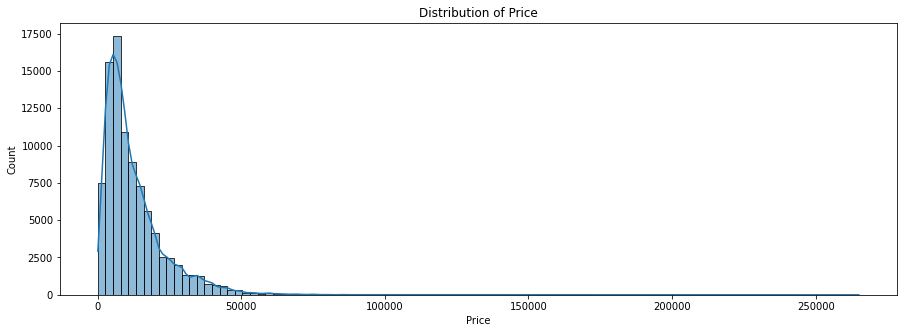

In [245]:
plt.figure(figsize = (15, 5))
plt.ticklabel_format(style = "plain")
sns.histplot(data = cars_linear_data, x = "price", bins = 100, kde = True)
plt.xlabel("Price")
plt.title("Distribution of Price")

In [246]:
X_linear = cars_linear_data.iloc[:, 1:]
y_linear = cars_linear_data["price"]

X_with_constant = sm.add_constant(X_linear)
est = sm.OLS(y_linear, X_with_constant)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     452.4
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:12:46   Log-Likelihood:            -9.5815e+05
No. Observations:               91548   AIC:                         1.917e+06
Df Residuals:                   91413   BIC:                         1.918e+06
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [247]:
est2.mse_model

32690580880.450516

#### Log Transformation

In [248]:
cars_linear_log_price = cars_linear_data.copy()
cars_linear_log_price["log_price"] = np.log(cars_linear_log_price["price"])
#cars_linear_log_price = cars_linear_log_price.iloc[:, [-1] + [0:-1]]
cars_linear_log_price.drop("price", axis = 1)

,year,cylinders,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,...,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,log_price
0,2003.00000,4.00000,243000.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.43348
1,2007.00000,8.00000,254217.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.74067
2,2012.00000,6.00000,188406.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.54646
3,2010.00000,4.00000,108124.00000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.98657
4,2011.00000,6.00000,178054.00000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9.10442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91543,2012.00000,4.00000,82000.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.19877
91544,2002.00000,4.00000,40000.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.62007
91545,2002.00000,6.00000,58000.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.47637
91546,2006.00000,6.00000,159980.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.37776


Text(0.5, 1.0, 'Distribution of the Natural Log of Price')

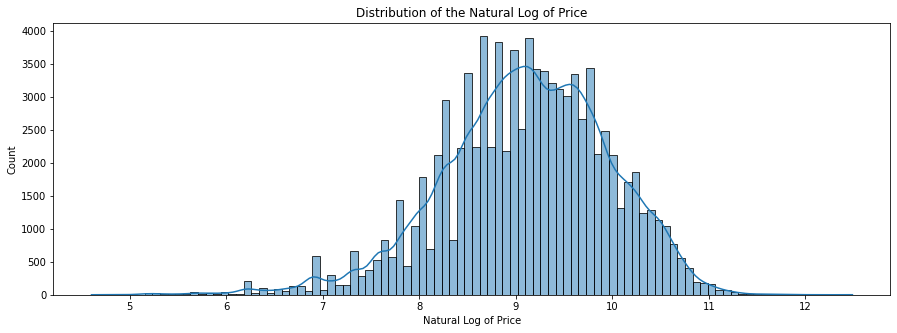

In [253]:
plt.figure(figsize = (15, 5))
plt.ticklabel_format(style = "plain")
sns.histplot(data = cars_linear_log_price, x = "log_price", bins = 100, kde = True)
plt.xlabel("Natural Log of Price")
plt.title("Distribution of the Natural Log of Price")

In [250]:
X_linear = cars_linear_log_price.iloc[:, 0:-1]
y_linear = cars_linear_log_price["log_price"]

X_with_constant = sm.add_constant(X_linear)
est = sm.OLS(y_linear, X_with_constant)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     2450.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:13:50   Log-Likelihood:                -46835.
No. Observations:               91548   AIC:                         9.394e+04
Df Residuals:                   91412   BIC:                         9.522e+04
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [251]:
est2.mse_model

399.6337955386022

### Naive Bayes

In [257]:
X = cars_price_binned.iloc[:, 1:]
y = cars_price_binned.iloc[:, 0]

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 212)

In [281]:
#Bernoulli Naive Bayes
BNB = BernoulliNB()

BNB.fit(X_train, y_train)

y_pred = BNB.predict(X_test)
print("Naive Bayes overall accuracy:", accuracy_score(y_test, y_pred))

Naive Bayes overall accuracy: 0.45536394028665056


Naive Bayes overall accuracy using 10-fold cross validation: 0.4511950015292524
       0     1     2      3
0  15605  2406  3536   1337
1   5142  8700  3327   5707
2   8420  6660  4725   3072
3   3780  5122  1733  12276


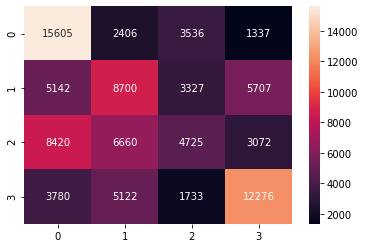

In [285]:
predictions = cross_val_predict(BNB, X, y, cv = 10)
print("Naive Bayes overall accuracy using 10-fold cross validation:", accuracy_score(y, predictions))
cm = pd.DataFrame(confusion_matrix(y, predictions))
sns.heatmap(cm, annot = True, fmt = "g")
print(cm)

### Random Forest

In [261]:
X = cars_price_binned.iloc[:, 1:]
y = cars_price_binned.iloc[:, 0]

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 212)

In [263]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

model.score(X_test, y_test)

RandomForestClassifier()

Random Forest overall accuracy using 10-fold cross validation: 0.791967055533709
       0      1      2      3
0  20222    287   2214    161
1    242  16283   2994   3357
2   2158   2960  17192    567
3    300   3304    501  18806


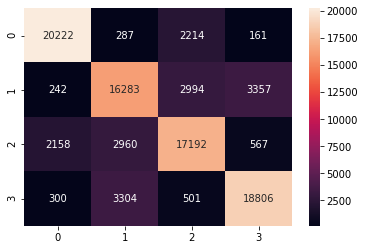

In [286]:
predictions = cross_val_predict(model, X, y, cv = 10)
print("Random Forest overall accuracy using 10-fold cross validation:", accuracy_score(y, predictions))
cm = pd.DataFrame(confusion_matrix(y, predictions))
sns.heatmap(cm, annot = True, fmt = "g")
print(cm)
#cross_val_score(RandomForestClassifier(), X, y, cv = 10).mean()

## Feature Selection

In [287]:
mutual_info = mutual_info_classif
info = mutual_info(X_train, y_train)
info_dict = dict(list(enumerate(info)))
values = sorted(info_dict.values(), reverse = True)

In [288]:
info_gain = pd.DataFrame(info_dict, index = [0]).transpose()
info_gain.columns = ["info_gain"]
info_gain["variable"] = list(X.columns)
info_gain = info_gain.iloc[:, [-1,0]].sort_values(by = "info_gain", ascending = False)
info_gain.head(15)

,variable,info_gain
2,odometer,0.34738
0,year,0.28433
60,drive_fwd,0.05704
1,cylinders,0.04268
69,type_sedan,0.03801
70,type_truck,0.03638
44,condition_fair,0.03585
59,transmission_other,0.01856
50,fuel_gas,0.01827
45,condition_good,0.01480


There are 10 variables which have an information gain over 0.01. Let's reduce the number of variables and only use those to test our models.

In [86]:
top_10 = list(info_gain[0:10].index)

In [87]:
X_cut = cars_price_binned.iloc[:, 1:].iloc[:, top_10]
y = cars_price_binned.iloc[:, 0]

In [88]:
X_cut.head()

,odometer,year,drive_fwd,cylinders,type_truck,type_sedan,condition_fair,fuel_gas,condition_good,condition_like new
0,243000.00000,2003.00000,0,4.00000,0,1,0,1,1,0
1,254217.00000,2007.00000,0,8.00000,1,0,0,0,1,0
2,188406.00000,2012.00000,0,6.00000,1,0,0,1,1,0
3,108124.00000,2010.00000,0,4.00000,0,0,0,1,1,0
4,178054.00000,2011.00000,0,6.00000,0,0,0,1,1,0


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_cut, y, test_size = 0.33, random_state = 212)

### Naive Bayes

In [90]:
#Bernoulli Naive Bayes
BNB = BernoulliNB()

BNB.fit(X_train, y_train)
print(BNB)

y_pred = BNB.predict(X_test)
print(accuracy_score(y_test, y_pred))

BernoulliNB()
0.4127304624143524


In [91]:
cross_val_score(BNB, X_cut, y, cv = 10).mean()

0.41086651050231326

### Random Forest

In [92]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [93]:
model.score(X_test, y_test)

0.7140114527820992

In [94]:
cross_val_score(RandomForestClassifier(), X_cut, y, cv = 10).mean()

0.7122274266400032

## Plots Based on Analysis

Text(0.5, 1.0, 'Scatterplot of Price and Odometer Colored by Nationality')

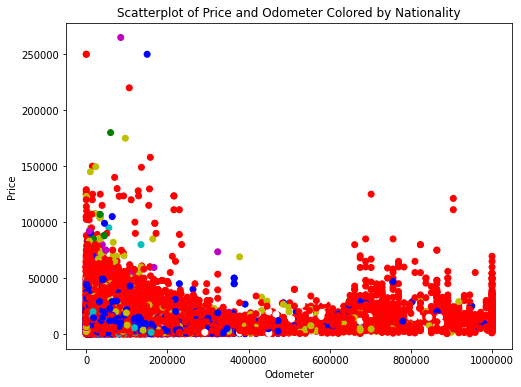

In [95]:
plt.figure(figsize = (8, 6))
plt.ticklabel_format(style = "plain")
plt.scatter(cars_linear_data["odometer"], cars_linear_data["price"], c = categorical["nationality_colors"])
plt.xlabel("Odometer")
plt.ylabel("Price")
plt.title("Scatterplot of Price and Odometer Colored by Nationality")

Text(0.5, 1.0, 'Scatterplot of Price and Year Colored by Nationality')

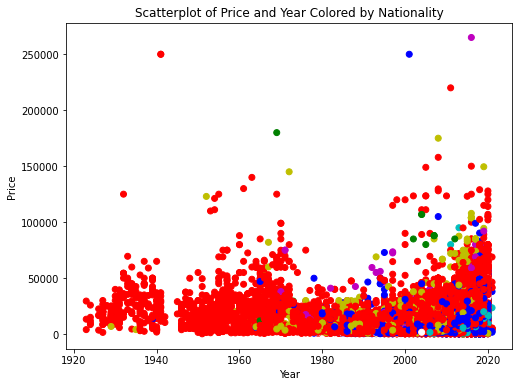

In [96]:
plt.figure(figsize = (8, 6))
plt.ticklabel_format(style = "plain")
plt.scatter(cars_linear_data["year"], cars_linear_data["price"], c = categorical["nationality_colors"])
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Scatterplot of Price and Year Colored by Nationality")